In [1]:
import sys
import os

sys.path.append('/import/silo2/aloe8475/Documents/edamame') #point to edamame locally
sys.path.append('/import/silo2/aloe8475/Documents/CODE/Analysis/Training/Associative Learning/EquilProp') #point to edamame locally
sys.path.append('/import/silo2/aloe8475/Documents/CODE/aux_functions/') #point to edamame locally

dataLoc='/import/silo2/aloe8475/Documents/Data/Associative Learning/EquilProp/'
#point to network data path ^ 

#saveFig='/import/silo2/aloe8475/Documents/Data/Figures/Equil Prop/' 

#import edamame (neuromorphic nanowire python package by Ruomin Zhu)
from edamame import * 
import numpy as np
import matplotlib.pyplot as plt
import copy
from scipy.io import loadmat, savemat
import networkx as nx
from tqdm.notebook import tqdm_notebook as tqdm
from IPython.core.debugger import set_trace

from matplotlib import animation
from matplotlib import colorbar as clbr
from PIL import Image
from matplotlib.ticker import LogFormatter 
from matplotlib import rcParams
from create_colormap import get_continuous_cmap,hex_to_rgb,rgb_to_dec

import pickle 
import _pickle as cPickle
import gzip

In [2]:
#Functions:
def getWeightedGraph(adjMat,jC,jV,jF,edgeList,numWires,time,edge_mode):#, this_TimeStamp = 0):
#     edgeList = network['edge_list']
    adjMat = np.zeros((numWires, numWires))
#     set_trace()
    if edge_mode=='conductance':
        adjMat[edgeList[:,0], edgeList[:,1]] = jC[time,:]#network.junctionSwitch[this_TimeStamp,:] #CHANGE THIS TO CONDUCTANCE THRESHOLD?
        adjMat[edgeList[:,1], edgeList[:,0]] = jC[time,:]#network.junctionSwitch[this_TimeStamp,:] #CHANGE THIS TO CONDUCTANCE THRESHOLD?
        maxWeights=np.max(jC)

    elif edge_mode=='current':
        adjMat[edgeList[:,0], edgeList[:,1]] = jV[time,:]*jC[time,:]
        adjMat[edgeList[:,1], edgeList[:,0]] = jV[time,:]*jC[time,:]
        maxWeights=np.max(jV*jC)
        
        
    elif edge_mode=='filament':
        adjMat[edgeList[:,0], edgeList[:,1]] = jF[time,:]
        adjMat[edgeList[:,1], edgeList[:,0]] = jF[time,:]
        
    WeightedGraph = nx.from_numpy_array(adjMat)
    WeightedGraph=nx.DiGraph.to_undirected(WeightedGraph)
    
    return WeightedGraph

def image_draw_voltage(time,cmap,maxWeights,minWeights):
    ax.clear() 
    pos=nx.kamada_kawai_layout(g)
           
    #ALON'S CODE:    
    node_weight=sim.wireVoltage[time]

    pos=nx.kamada_kawai_layout(g)
    nodeList=g.nodes
    numWires=g.number_of_nodes()

    h=nx.draw_networkx_nodes(g,pos=pos,node_color=node_weight,cmap=cmap,node_size=50,ax=ax)

    h2=nx.draw_networkx_edges(G,pos=pos,ax=ax,edge_color='grey')
    # nx.draw_networkx_nodes(g,pos=pos,nodelist=sources,node_color='g',node_size=50,ax=ax)
    nx.draw_networkx_nodes(g,pos=pos,nodelist=[drains[1]],node_color='r',node_size=10,ax=ax)
    nx.draw_networkx_nodes(g,pos=pos,nodelist=[drains[0]],node_color='b',node_size=10,ax=ax)
    ax.set_title(str(time))
    
import matplotlib.colors as clrs

def image_draw_current_filament(time,edge_mode,edge_weight,cmap,maxWeights,minWeights):
    ax.clear() 
#     pos=nx.kamada_kawai_layout(g)
        
    #RUOMIN'S CODE:
#     draw_graph(sim,time,edge_mode=edge_mode,edge_weight=edge_weight,edge_colorbar=False,node_size=30,figsize=(10,8),edge_cmap=cmap,with_labels=False,norm=True,ax=ax,maxWeight=maxWeights,minWeight=minWeights)

    #ALON'S CODE:    
    
#     edge_mode=animationType
#     edgeList=sim.connectivity.edge_list
#     numWires=g.number_of_nodes()
#     G=getWeightedGraph(sim,edgeList,numWires,time,edge_mode)
    
    pos=nx.kamada_kawai_layout(g)
    edgeList=sim[0].connectivity.edge_list
    numWires=g.number_of_nodes()
    G=getWeightedGraph(adjMat,jC,jV,jF,edgeList,numWires,time,animationType)#, this_TimeStamp = 0):

    edge_weights=nx.get_edge_attributes(G,'weight')
#     G.remove_edges_from((e for e, w in edge_weights.items() if w <1e-)) 
    
    edges=G.edges()
    weights=[G[u][v]['weight'] for u,v in edges]
    
    if animationType=='filament':
        logVal=1e-7
    else:
        logVal=1e-7
    
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=clrs.SymLogNorm(logVal,base=10,vmin=minWeights, vmax=maxWeights))
    sm.set_array([])
    normweights=sm.norm(weights).data
    if len(normweights)==0:
        normweights=np.zeros(g.number_of_edges())
    
    normMin=sm.norm(minWeights)
    normMax=sm.norm(maxWeights)
    h=nx.draw_networkx_nodes(g,pos=pos,node_color='grey',node_size=20,ax=ax)
#     h.set_zorder(1)
    h2=nx.draw_networkx_edges(G,pos=pos,ax=ax,edge_color=normweights,width=2,edge_cmap=cmap,edge_vmin=normMin,edge_vmax=normMax,alpha=0.7)
    if targetValsTime[time] == 0:
        nx.draw_networkx_nodes(g,pos=pos,nodelist=sources,node_color='k',node_size=100,ax=ax)
        nx.draw_networkx_nodes(g,pos=pos,nodelist=list(activeSources[0]),node_color='g',node_size=100,ax=ax)
        
        if time in testTimes:
            nx.draw_networkx_nodes(g,pos=pos,nodelist=drains,node_color='r',node_size=100,ax=ax)
        else:
            nx.draw_networkx_nodes(g,pos=pos,nodelist=[drains[0]],node_color='r',node_size=100,ax=ax)
            nx.draw_networkx_nodes(g,pos=pos,nodelist=[drains[1]],node_color='k',node_size=100,ax=ax)
    else:
        nx.draw_networkx_nodes(g,pos=pos,nodelist=sources,node_color='k',node_size=100,ax=ax)
        nx.draw_networkx_nodes(g,pos=pos,nodelist=list(activeSources[4]),node_color='g',node_size=100,ax=ax) #need to write this better
        
        if time in testTimes:
            nx.draw_networkx_nodes(g,pos=pos,nodelist=drains,node_color='r',node_size=100,ax=ax)
        else:
            nx.draw_networkx_nodes(g,pos=pos,nodelist=[drains[1]],node_color='r',node_size=100,ax=ax)
            nx.draw_networkx_nodes(g,pos=pos,nodelist=[drains[0]],node_color='k',node_size=100,ax=ax)

    
    # shift position a little bit
    shift = [-0.1, 0]
    shifted_pos ={node: node_pos + shift for node, node_pos in pos.items()}
#     set_trace()
    # Just some text to print in addition to node ids  
    
    labels = {}
    for node in g.nodes():
        if node in drains:
        #set the node name as the key and the label as its value 
            labels[node] = node
#     labels[1] = 'Drain 1'
#     labels[2] = 'Drain 2'
    nx.draw_networkx_labels(g, shifted_pos, labels=labels, horizontalalignment="left")
    if time in testTimes:
        timeVals='Testing'
    else:
        timeVals='Training'
    
    ax.set_title('T = ' + str(time)+ ' | ' + timeVals + ' | Target ' + str(targetValsTime[time]))

    
#New loadmat:
import scipy.io as spio

def loadmatNew(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], spio.matlab.mio5_params.mat_struct):
            dict[key] = _todict(dict[key])
    return dict        

def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, spio.matlab.mio5_params.mat_struct):
            dict[strg] = _todict(elem)
        else:
            dict[strg] = elem
    return dict


In [ ]:
plt.plot(targetValsTime)

In [81]:
saveFig='/import/silo2/aloe8475/Documents/Data/Figures/Equil Prop/'

In [82]:
pwd

'/import/silo2/aloe8475/Documents/CODE/Analysis/Training/Associative Learning/EquilProp/n-back'

In [83]:
nback=2

In [84]:
ManualSources=True

loadFile='data_698nw_2582nj_3x3_wThresh_Vtrn0.3_Vtst0.1_beta005_T200_oneDrainTrain_nback3_df'

file = open(dataLoc+loadFile+'.pkl','rb')
#load data
df = pickle.load(file)


In [4]:
#load data:
loadFile='data_698nw_2582nj_3x3_wThresh_Vtrn0.3_Vtst0.1_beta005_T200_oneDrainTrain_nback3.mat'
out=loadmatNew(dataLoc+loadFile)
out=out['Data']
currents=out['current']
thresholds=out['threshold']
sim=out['sim']
accuracy=out['accuracy']
alltargets=out['targets']
targetValsTime=alltargets.reshape(-1)
trainingOrder=out['training order']
trainingLabels=out['training labels']
testingLabels=out['testing labels']
allLabels=out['all labels']
numTestingSamples=out['num test samples']
params=out['Parameters']

In [6]:
targetValsTime.shape

(32800,)

In [86]:
vals=[]
for i in range(len(df)):
    vals.append(np.arange(df['Test Time Start'].values[i],df['Test Time End'].values[i]))

In [87]:
testTimes=np.array(vals).reshape(-1)

In [88]:
signalLen=df['Test Time End'].values[-1]-df['Train Time Start'].values[0]

In [89]:
targets=df['Class'].values

In [90]:
df['Train Time End'].values[-1]

31799

In [91]:
numDT=20
triallen=len(targets)
xlims=[df['Train Time Start'].values[0],df['Test Time Start'].values[-1]]


In [92]:
xlims

[0, 31800]

In [93]:
#load network
# fileName='/import/silo2/aloe8475/Documents/Data/Associative Learning/Sparse Networks/asn_nw_00350_nj_01350_seed_1581_avl_10.00_disp_01.00_lx_50.00_ly_50.00'
nw=loadmat('/import/silo2/aloe8475/Documents/Data/Associative Learning/Sparse Networks/asn_nw_00698_nj_02582_seed_002_avl_10.00_disp_01.00_lx_75.00_ly_75.00')

# nw=loadmat(fileName)
g=nx.from_numpy_array(nw['adj_matrix'])
adjMat=nw['adj_matrix']

In [94]:
# import seaborn as sns

# plt.rcParams.update(plt.rcParamsDefault)
# x=sim.electrodeCurrent[:,:2]
# plt.figure(figsize=(10,8))
# plt.plot(x[:,0],color='b')

# plt.plot(x[:,1],color='r')
# ax=plt.gca()
# # ax.set_xlim(xlims)
# ax.set_xlim([-30,1230])

# colrs=[]
# for val in df['Class']:
#     if val <= 1:
#         colrs.append('C1')
#     else:
#         colrs.append('C2')


# ax2=ax.twinx().twiny()

# ax2.set_xticks(np.array(range(40,len(x)-10,60))/20)

# testTimeVals=list(df['OrderVal']*3+3)


# sns.scatterplot(x=testTimeVals[:-1],y='Accuracy',data=df[:-1],hue=colrs[:-1],palette=['r','b'],ax=ax2)
# ax2.legend(title='Accuracy',loc='lower left')
# ax2.set_xlim([-20/20,1240/20])
# ax2.set_ylabel('Accuracy')

# # ax2=plt.twinx()
# # ax2.set_xlim(xlims)
# # plt.scatter(np.arange(triallen),a,marker='_',color=colrs)


In [254]:
# mask=np.in1d(np.arange(triallen),testTime)
# a=targets.astype(float)
# a[~mask]=np.nan
# colrs=[]
# for val in a:
#     if val > 0:
#         colrs.append('r')
#     else:
#         colrs.append('b')

In [95]:
# drains=sim.electrodes[:2]
# sources=sim.electrodes[2:]
#700nw 3x3:
sources = [678, 260, 491, 173, 628, 424, 301, 236, 483]
drains = [600, 399]
#350nw 3x3:
# sources=[23,320,194,74, 145, 317, 129, 34, 141]
# drains:

#350nw 2x2:
# sources=[320, 42, 161, 141]
# drains = [189, 180]


onAmp=0.3
onAmpTest=0.1

###  Draw Drain Current Plot:


In [96]:
# plt.rcParams.update(plt.rcParamsDefault)

# duration = len(range(xlims[0],xlims[1],1)[::10]) # in sec
# refreshPeriod = 10 # in ms

# fig,ax = plt.subplots(1,1, figsize=(10, 8), dpi=300)
# vl = ax.axvline(0, ls='-', color='k', lw=1, zorder=10)

# x=sim.electrodeCurrent[:,:2]
# ax.plot(x[:,0],color='b')

# ax.plot(x[:,1],color='r')
# # ax.set_xlim(xlims)
# ax.set_xlim([-30,1230])

# colrs=[]
# for val in df['Class']:
#     if val <= 1:
#         colrs.append('C1')
#     else:
#         colrs.append('C2')


# ax2=ax.twinx().twiny()

# ax2.set_xticks(np.array(range(40,len(x)-10,60))/20)

# testTimeVals=list(df['OrderVal']*3+3)


# sns.scatterplot(x=testTimeVals[:-1],y='Accuracy',data=df[:-1],hue=colrs[:-1],palette=['r','b'],ax=ax2)
# ax2.legend(title='Accuracy',loc='lower left')
# ax2.set_xlim([-20/20,1240/20])
# ax2.set_ylabel('Accuracy')


# plt.show()


# if ManualSources:
#     fig.savefig(saveFig+'currents_nback_manualsources.png')
# else:
#     fig.savefig(saveFig+'currents_nback.png')
# def animate(i,vl,period):
#     t = i 
# #     set_trace()
#     vl.set_xdata([t,t])
#     return vl,

# ani = animation.FuncAnimation(fig, animate, frames=range(xlims[0],xlims[1],1)[::10], fargs=(vl,refreshPeriod), interval=refreshPeriod)
# # plt.show()

In [97]:
# currentPath=os.getcwd()
# FFwriter = animation.FFMpegWriter()
# os.chdir(saveFig)
# if ManualSources:
#     ani.save('nback_timestep_track_trial9_t'+str(xlims[0])+'_'+str(xlims[1])+'_manualsources.mp4', fps=10,
#               progress_callback = lambda i, n: print(f'Saving frame {i} of {n}'),)
# else:
#     ani.save('nback_timestep_track_trial9_t'+str(xlims[0])+'_'+str(xlims[1])+'.mp4', fps=10,
#               progress_callback = lambda i, n: print(f'Saving frame {i} of {n}'),)

# os.chdir(currentPath)

In [98]:
# x[779]

In [99]:
# #INPUTS:
# fig,axes=plt.subplots(2,3,figsize=(10,8))
# ax=axes[0,0]
# a=ax.imshow(np.hstack((trainInputs[[10,11]].T*onAmp,testInputs[5].reshape(7,1)*onAmpTest)))
# plt.colorbar(a,ax=ax,label='Vin')
# ax.set_title('t = 360 | class = 1 | acc = 1')
# ax.set_xticks([0,1,2])
# ax.set_xticklabels(['Train1','Train2','Test'])
# ax=axes[0,1]
# b=ax.imshow(np.hstack((trainInputs[[24,25]].T*onAmp,testInputs[12].reshape(7,1)*onAmpTest)))
# ax.set_title('t = 780 | class = 2 | acc = 0')
# ax.set_xticks([0,1,2])
# ax.set_xticklabels(['Train1','Train2','Test'])
# plt.colorbar(b,ax=ax,label='Vin')

# ax=axes[0,2]
# c=ax.imshow(np.hstack((trainInputs[[30,31]].T*onAmp,testInputs[15].reshape(7,1)*onAmpTest)))
# plt.colorbar(c,ax=ax,label='Vin')
# ax.set_title('t = 960 | class = 2 | acc = 1')
# ax.set_xticks([0,1,2])
# ax.set_xticklabels(['Train1','Train2','Test'])

# ax=axes[1,0]
# a=ax.imshow(x[359,[0,1]].reshape(1,2),vmin=0,vmax=1.5e-5)
# plt.colorbar(a,ax=ax,label='Iout')
# ax.set_xticks([0,1])

# ax.set_xticklabels(['Drain 1','Drain 2'])
# ax.set_yticks([])
# ax=axes[1,1]
# b=ax.imshow(x[779,[0,1]].reshape(1,2),vmin=0,vmax=1.5e-5)
# plt.colorbar(b,ax=ax,label='Iout')
# ax.set_xticks([0,1])

# ax.set_xticklabels(['Drain 1','Drain 2'])
# ax.set_yticks([])
# ax=axes[1,2]
# c=ax.imshow(x[959,[0,1]].reshape(1,2),vmin=0,vmax=1.5e-5)
# ax.set_xticks([0,1])
# ax.set_xticklabels(['Drain 1','Drain 2'])
# ax.set_yticks([])

# plt.colorbar(c,ax=ax,label='Iout')
# plt.show()

###  Draw Network Junction Current/Conductance:


In [100]:
simList=[]
for s in sim:
    simList.append(_todict(s))

In [102]:
nwJunctions=nw['number_of_junctions'][0][0]
nwWires=nw['number_of_wires'][0][0]

In [101]:
#combine all sim voltages, conductance and filament together
jV=[]
jF=[]
jC=[]
activeSources=[]
for i in range(len(simList)):
    jV.append(simList[i]['junctionVoltage'])    
    jF.append(simList[i]['filamentState']) #Junction Filament Negative
    jC.append(simList[i]['junctionConductance'])
    activeSources.append(simList[i]['sources'])

In [104]:
jV=np.array(jV).reshape(164*200,nwJunctions) #164 for nback 3, 119 for nback 2
jF=np.array(jF).reshape(164*200,nwJunctions)
jC=np.array(jC).reshape(164*200,nwJunctions)

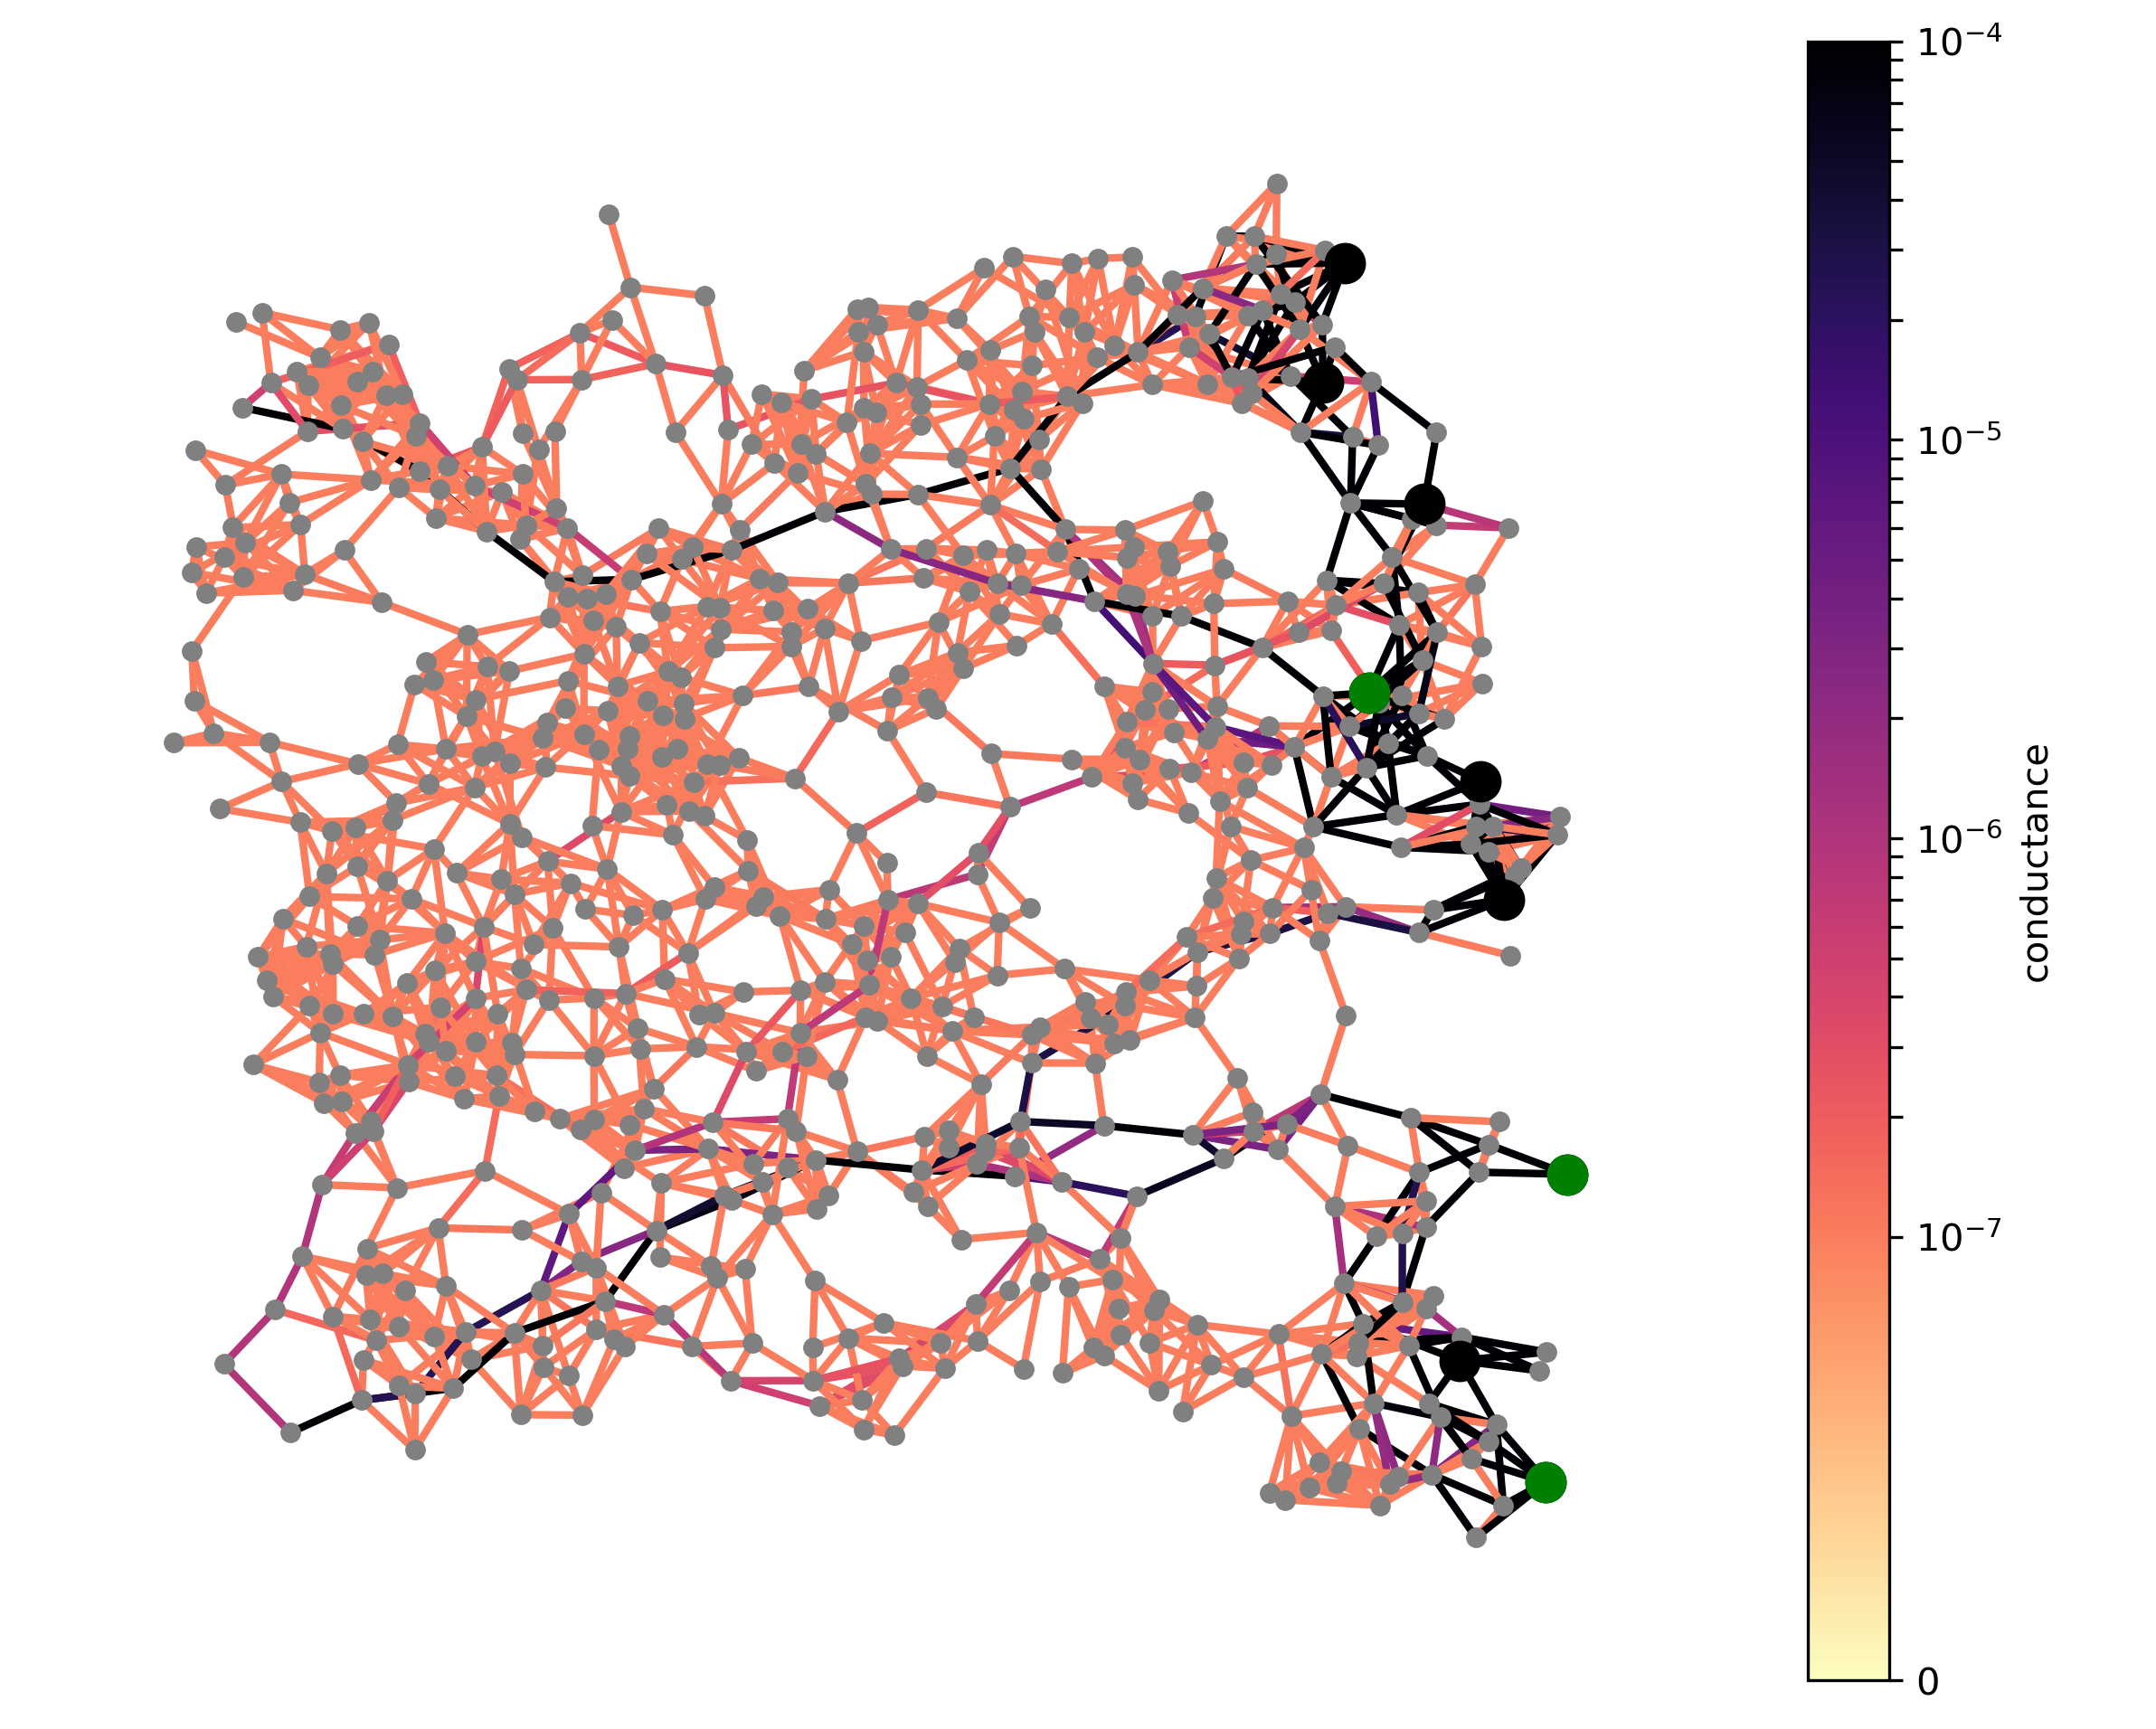

In [106]:
plt.close('all')
rcParams['animation.embed_limit'] = 2**64


edge_mode='custom'
animationType = 'conductance'


if animationType =='current':
    minWeights=0
    jI=np.array(jV*jC)
    edge_weight = jI
    maxWeights=np.max(jI)
    cmap=plt.cm.magma_r
elif animationType== 'conductance':
    minWeights=0
    maxWeights=np.max(jC)
    cmap=plt.cm.magma_r
    edge_weight=jC
elif animationType== 'filament':
    minWeights=0
    maxWeights=np.max(jF)
    colorlist=["950700","c93a28","fd6c50","fb986a","f7c59f","efd6b8","e6e6d0"]


    colorlist.reverse()
    cmap=get_continuous_cmap(colorlist) #hexlist
#     cmap=plt.cm.Pastel1
    edge_weight=jF
    #binary threshold (only show above or below a certain value)

f,[ax,cax] = plt.subplots(1,2, gridspec_kw={"width_ratios":[50,1]},frameon=False, figsize=(10, 8), dpi=300)
canvas_width, canvas_height = f.canvas.get_width_height()
ax.axis('off')
cax.axis('off')

# clrplt=np.linspace(minWeights,maxWeights,1000).reshape(1000,1)
# img=cax.imshow(clrplt,cmap=cmap,norm=clrs.LogNorm())
# cax.set_visible(False)
# formatter = LogFormatter(10, labelOnlyBase=True) 
# norm=clrs.SymLogNorm(1,base=10,vmin=minWeights,vmax=maxWeights)
# cb1=clbr.ColorbarBase(cax,cmap=cmap,norm=norm)


pos=nx.kamada_kawai_layout(g)
edgeList=sim[0].connectivity.edge_list
numWires=g.number_of_nodes()
G=getWeightedGraph(adjMat,jC,jV,jF,edgeList,numWires,20000,animationType)#, this_TimeStamp = 0):

# edge_weights=nx.get_edge_attributes(G,'weight')
# G.remove_edges_from((e for e, w in edge_weights.items() if w <1e-10)) 

edges=G.edges()
weights=[G[u][v]['weight'] for u,v in edges]

# normweights = (np.array(weights)-minWeights) / (maxWeights - minWeights)
# weights = [cmap(color_normal(e)) for e in weights]
sm = plt.cm.ScalarMappable(cmap=cmap, norm=clrs.SymLogNorm(1e-7,base=10,vmin=minWeights, vmax=maxWeights))
sm.set_array([])

normweights=sm.norm(weights).data
normMin=sm.norm(minWeights)
normMax=sm.norm(maxWeights)

h=nx.draw_networkx_nodes(g,pos=pos,node_color='grey',node_size=20,ax=ax)

h2=nx.draw_networkx_edges(G,pos=pos,ax=ax,edge_color=normweights,width=2,edge_cmap=cmap,edge_vmin=normMin,edge_vmax=normMax)
if targetValsTime[20000] == 0:
    nx.draw_networkx_nodes(g,pos=pos,nodelist=sources,node_color='k',node_size=100,ax=ax)
    nx.draw_networkx_nodes(g,pos=pos,nodelist=list(activeSources[0]),node_color='g',node_size=100,ax=ax)
else:
    nx.draw_networkx_nodes(g,pos=pos,nodelist=sources,node_color='k',node_size=100,ax=ax)
    nx.draw_networkx_nodes(g,pos=pos,nodelist=list(activeSources[4]),node_color='g',node_size=100,ax=ax) #need to write this better



cbar = plt.colorbar(sm, ax=ax,
                    fraction = 0.05, label=animationType)


anim1 = animation.FuncAnimation(f, image_draw_current_filament, 
                               frames=range(xlims[0],xlims[1],1)[::100], 
                               interval=20, 
                               repeat=False,fargs=(edge_mode,edge_weight,cmap,maxWeights,minWeights))


In [47]:
jF

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-5.90006544e-06,  0.00000000e+00,  0.00000000e+00, ...,
        -1.67741998e-05, -8.56561230e-02, -1.00292315e-05],
       [ 1.40999346e-05,  0.00000000e+00,  0.00000000e+00, ...,
         3.22580019e-06, -8.56361230e-02,  9.97076853e-06],
       [-5.90006544e-06,  0.00000000e+00,  0.00000000e+00, ...,
        -1.67741998e-05, -8.56161230e-02, -1.00292315e-05]])

In [53]:
np.histogram(jF,bins=10
    0)

(array([ 1407812,   345244,   362780,  1252021,  1643484,   790399,
          803654,   872975,  1288112, 18505782, 25414536,  1402726,
          981780,   734416,   832758,  1819239,  1291630,   293626,
          224140,  1184486]),
 array([-0.15 , -0.135, -0.12 , -0.105, -0.09 , -0.075, -0.06 , -0.045,
        -0.03 , -0.015,  0.   ,  0.015,  0.03 ,  0.045,  0.06 ,  0.075,
         0.09 ,  0.105,  0.12 ,  0.135,  0.15 ]))

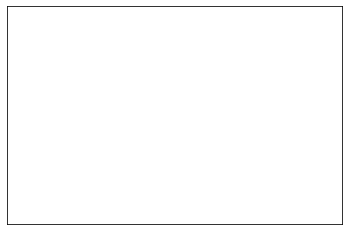

In [401]:
#Draw Example Time:
plt.figure()
time = 110
image_draw_current_filament(time,edge_mode,edge_weight,cmap,maxWeights,minWeights)
plt.show()

In [326]:
# #CURRENT/CONDUCTANCE/FILAMENT FRAMES
# times=[360,780]
# fig,axes=plt.subplots(1,2,figsize=(10,4),dpi=300)

# animationType='current'

# if animationType =='current':
#     minWeights=0
#     junctionCurrents=np.array(sim.junctionVoltage*sim.junctionConductance)
#     edge_weights = junctionCurrents
#     maxWeights=np.max(junctionCurrents)
#     cmap=plt.cm.magma_r
# elif animationType== 'conductance':
#     minWeights=0
#     maxWeights=np.max(sim.junctionConductance)
#     cmap=plt.cm.coolwarm
#     edge_weights=sim.junctionConductance

# for i in range(len(axes)):
#     ax=axes[i]
#     time=times[i]

#     edge_weight=edge_weights[time]
    
#     pos=nx.kamada_kawai_layout(g)
#     nodeList=g.nodes
#     numWires=g.number_of_nodes()
#     edgeList=sim.connectivity.edge_list
#     G=getWeightedGraph(sim,edgeList,numWires,time,animationType)

#     edges=G.edges()
#     weights=[G[u][v]['weight'] for u,v in edges]

#     sm = plt.cm.ScalarMappable(cmap=cmap, norm=clrs.SymLogNorm(1e-8,base=10,vmin=minWeights, vmax=maxWeights))
#     sm.set_array([])

#     normweights=sm.norm(weights).data
#     normMin=sm.norm(minWeights)
#     normMax=sm.norm(maxWeights)

#     h=nx.draw_networkx_nodes(g,pos=pos,node_color='grey',node_size=10,ax=ax,alpha=0.7)

#     h2=nx.draw_networkx_edges(G,pos=pos,ax=ax,edge_color=normweights,width=1.5,edge_cmap=cmap,edge_vmin=normMin,edge_vmax=normMax)
#     nx.draw_networkx_nodes(g,pos=pos,nodelist=sources,node_color='g',node_size=50,ax=ax)
#     nx.draw_networkx_nodes(g,pos=pos,nodelist=[drains[1]],node_color='r',node_size=50,ax=ax)
#     nx.draw_networkx_nodes(g,pos=pos,nodelist=[drains[0]],node_color='b',node_size=50,ax=ax)
#     ax.set_title(str(time))
    
#     cbar = plt.colorbar(sm, ax=ax,
#                     fraction = 0.05, label=animationType)

# if ManualSources:
#     fig.savefig(saveFig+'junction'+str(animationType)+'_trial9_t'+str(times[0])+'_vs_'+str(times[1])+'_manualsources.png')
# else:
#     fig.savefig(saveFig+'junction'+str(animationType)+'_trial9_t'+str(times[0])+'_vs_'+str(times[1])+'.png')


In [53]:
plt.close('all')

In [430]:
len(activeSources)

119

In [421]:


simList[0]['stimulus'][1].signal[0]

0.3

2022-04-08 11:40:37,908:INFO:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2022-04-08 11:40:37,911:INFO:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 3000x2400 -pix_fmt rgba -r 5 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y 698nw_2582nj_nback_3_3x3_oneDrain_explore_conductance_t0_31800.mp4


Saving frame 0 of 318
Saving frame 1 of 318
Saving frame 2 of 318
Saving frame 3 of 318
Saving frame 4 of 318
Saving frame 5 of 318
Saving frame 6 of 318
Saving frame 7 of 318
Saving frame 8 of 318
Saving frame 9 of 318
Saving frame 10 of 318
Saving frame 11 of 318
Saving frame 12 of 318
Saving frame 13 of 318
Saving frame 14 of 318
Saving frame 15 of 318
Saving frame 16 of 318
Saving frame 17 of 318
Saving frame 18 of 318
Saving frame 19 of 318
Saving frame 20 of 318
Saving frame 21 of 318
Saving frame 22 of 318
Saving frame 23 of 318
Saving frame 24 of 318
Saving frame 25 of 318
Saving frame 26 of 318
Saving frame 27 of 318
Saving frame 28 of 318
Saving frame 29 of 318
Saving frame 30 of 318
Saving frame 31 of 318
Saving frame 32 of 318
Saving frame 33 of 318
Saving frame 34 of 318
Saving frame 35 of 318
Saving frame 36 of 318
Saving frame 37 of 318
Saving frame 38 of 318
Saving frame 39 of 318
Saving frame 40 of 318
Saving frame 41 of 318
Saving frame 42 of 318
Saving frame 43 of 31

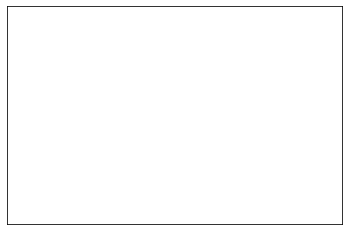

In [107]:
#MP4
currentPath=os.getcwd()
FFwriter = animation.FFMpegWriter()
os.chdir(saveFig)
# if ManualSources:
anim1.save(str(nwWires)+'nw_'+str(nwJunctions)+'nj_nback_3_3x3_oneDrain_explore_'+animationType+'_t'+str(xlims[0])+'_'+str(xlims[1])+'.mp4', fps=5,
          progress_callback = lambda i, n: print(f'Saving frame {i} of {n}'),)
# else:
#     anim1.save('nback_explore_'+animationType+'_trial9_t'+str(xlims[0])+'_'+str(xlims[1])+'_magmacmap.mp4', fps=10,
#               progress_callback = lambda i, n: print(f'Saving frame {i} of {n}'),)
os.chdir(currentPath)


In [444]:
activeSources[0]

array([678, 491, 424])

In [329]:
df

Class  Order  Trial  Accuracy  C1NoTest  C2NoTest  CountDiff  C1+Test  \
0       1  c1-c1     79     1.000         0         0         -1        0   
1       1  c1-c2     79     1.000         2         0         -2        3   
2       1  c1-c2     79     1.000         3         1         -3        5   
3       1  c1-c2     79     1.000         4         2         -4        7   
4       2  c2-c2     79     0.620         5         3         -3        9   
5       1  c1-c2     79     1.000         5         5         -4        9   
6       1  c1-c2     79     1.000         6         6         -5       11   
7       2  c2-c2     79     0.275         7         7         -4       13   
8       1  c1-c2     79     1.000         7         9         -5       13   
9       2  c2-c1     79     0.735         8        10         -4       15   
10      2  c2-c1     79     0.115         9        11         -3       16   
11      2  c2-c1     79     0.495        10        12         -2       17   
12      2  c2-c2     79     1.000        11        13         -1       18   
13      2  c2-c1     79     1.000        11        15          0       18   
14      2  c2-c1     79     1.000        12        16          1       19   
15      1  c1-c2     79     1.000        13        17          0       20   
16      1  c1-c2     79     0.925        14        18         -1       22   
17      1  c1-c1     79     0.895        15        19         -2       24   
18      2  c2-c1     79     0.915        17        19         -1       27   
19      1  c1-c1     79     0.935        18        20         -2       28   
20      1  c1-c2     79     1.000        20        20         -3       31   
21      2  c2-c1     79     0.800        21        21         -2       33   
22      2  c2-c1     79     1.000        22        22         -1       34   
23      2  c2-c2     79     1.000        23        23          0       35   
24      2  c2-c1     79     1.000        23        25          1       35   
25      2  c2-c2     79     1.000        24        26          2       36   
26      1  c1-c1     79     1.000        24        28          1       36   
27      2  c2-c1     79     1.000        26        28          2       39   
28      1  c1-c1     79     0.780        27        29          1       40   
29      2  c2-c2     79     1.000        29        29          2       43   
30      1  c1-c1     79     0.620        29        31          1       43   
31      1  c1-c2     79     0.955        31        31          0       46   
32      2  c2-c1     79     1.000        32        32          1       48   
33      1  c1-c1     79     0.975        33        33          0       49   
34      2  c2-c2     79     1.000        35        33          1       52   
35      1  c1-c1     79     1.000        35        35          0       52   
36      2  c2-c2     79     1.000        37        35          1       55   
37      1  c1-c2     79     0.975        37        37          0       55   
38      1  c1-c2     79     1.000        38        38         -1       57   
39      2  c2-c1     79       NaN        39        39          0       59   

    C2+Test  C1C1count  C1C2count  C2C1count  C2C2count  OrderVal  \
0         0          1          0          0          0         0   
1         0          1          1          0          0         1   
2         1          1          2          0          0         2   
3         2          1          3          0          0         3   
4         3          1          3          0          1         4   
5         6          1          4          0          1         5   
6         7          1          5          0          1         6   
7         8          1          5          0          2         7   
8        11          1          6          0          2         8   
9        12          1          6          1          2         9   
10       14          1          6          2          2        10   
11       16       

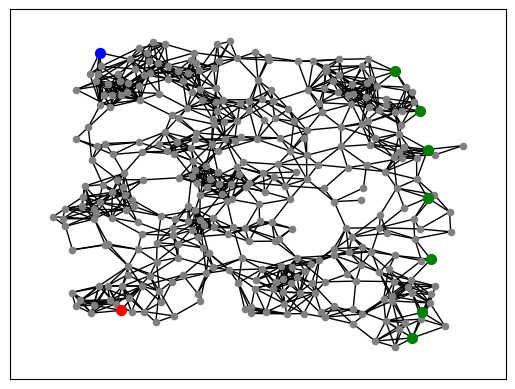

In [26]:
fig=plt.figure()
pos=nx.kamada_kawai_layout(g)
nx.draw_networkx(g,pos=pos,node_color='grey',with_labels=False,node_size=20)

nx.draw_networkx_nodes(g,pos=pos,nodelist=sources,node_color='g',node_size=50)
nx.draw_networkx_nodes(g,pos=pos,nodelist=[drains[1]],node_color='r',node_size=50)
nx.draw_networkx_nodes(g,pos=pos,nodelist=[drains[0]],node_color='b',node_size=50)

plt.show()
if ManualSources:
    fig.savefig(saveFig+'network_manualsources.png')
else:
    fig.savefig(saveFig+'network.png')

###  Draw Network Wire Voltages:


In [27]:
#VOLTAGE ANIMATION
times=[360,780]
fig,axes=plt.subplots(1,2,figsize=(10,4),dpi=300)

minWeights=0
maxWeights=np.max(sim.wireVoltage)
cmap=plt.cm.viridis

for i in range(len(axes)):
    ax=axes[i]
    time=times[i]
   
    node_weight=sim.wireVoltage[time]

    pos=nx.kamada_kawai_layout(g)
    nodeList=g.nodes
    numWires=g.number_of_nodes()

    h=nx.draw_networkx_nodes(g,pos=pos,node_color=node_weight,cmap=cmap,node_size=50,ax=ax,vmin=minWeights,vmax=maxWeights)

    h2=nx.draw_networkx_edges(G,pos=pos,ax=ax,edge_color='grey')
    # nx.draw_networkx_nodes(g,pos=pos,nodelist=sources,node_color='g',node_size=50,ax=ax)
    nx.draw_networkx_nodes(g,pos=pos,nodelist=[drains[1]],node_color='r',node_size=10,ax=ax)
    nx.draw_networkx_nodes(g,pos=pos,nodelist=[drains[0]],node_color='b',node_size=10,ax=ax)
    ax.set_title(str(time))
    plt.colorbar(h,ax=ax,label='V')

if ManualSources:
    fig.savefig(saveFig+'wireVoltage_trial9_t'+str(times[0])+'_vs_'+str(times[1])+'_manualsources.png')
else:
    fig.savefig(saveFig+'wireVoltage_trial9_t'+str(times[0])+'_vs_'+str(times[1])+'.png')


In [28]:
f,[ax,cax] = plt.subplots(1,2, gridspec_kw={"width_ratios":[50,1]},frameon=False, figsize=(10, 8), dpi=300)
canvas_width, canvas_height = f.canvas.get_width_height()
ax.axis('off')
cax.axis('off')


minWeights=0
maxWeights=np.max(sim.wireVoltage)
cmap=plt.cm.viridis


node_weight=sim.wireVoltage[0]

pos=nx.kamada_kawai_layout(g)
nodeList=g.nodes
numWires=g.number_of_nodes()

h=nx.draw_networkx_nodes(g,pos=pos,node_color=node_weight,cmap=cmap,node_size=50,ax=ax,vmin=minWeights,vmax=maxWeights)

h2=nx.draw_networkx_edges(G,pos=pos,ax=ax,edge_color='grey')
# nx.draw_networkx_nodes(g,pos=pos,nodelist=sources,node_color='g',node_size=50,ax=ax)
nx.draw_networkx_nodes(g,pos=pos,nodelist=[drains[1]],node_color='r',node_size=10,ax=ax)
nx.draw_networkx_nodes(g,pos=pos,nodelist=[drains[0]],node_color='b',node_size=10,ax=ax)


sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=minWeights, vmax=maxWeights))
sm.set_array([])

cbar = plt.colorbar(sm, ax=ax,
                    fraction = 0.05, label='V')

animV = animation.FuncAnimation(f, image_draw_voltage, 
                               frames=range(xlims[0],xlims[1],1)[::10], 
                               interval=20, 
                               repeat=False,fargs=(cmap,maxWeights,minWeights))


In [186]:
help(getWeightedGraph)

Help on function getWeightedGraph in module __main__:

getWeightedGraph(sims, edgeList, numWires, time, edge_mode)
    #Functions:



In [29]:
#MP4
currentPath=os.getcwd()
FFwriter = animation.FFMpegWriter()
os.chdir(saveFig)
if ManualSources:
    animV.save('nback_explore_voltage_trial9_t'+str(xlims[0])+'_'+str(xlims[1])+'_manualsources.mp4', fps=10,
              progress_callback = lambda i, n: print(f'Saving frame {i} of {n}'),)
else:
    animV.save('nback_explore_voltage_trial9_t'+str(xlims[0])+'_'+str(xlims[1])+'.mp4', fps=10,
              progress_callback = lambda i, n: print(f'Saving frame {i} of {n}'),)
os.chdir(currentPath)


2021-12-20 11:43:52,424:INFO:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2021-12-20 11:43:52,427:INFO:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 3000x2400 -pix_fmt rgba -r 10 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y nback_explore_voltage_trial9_t0_1199_manualsources.mp4


Saving frame 0 of 120
Saving frame 1 of 120
Saving frame 2 of 120
Saving frame 3 of 120
Saving frame 4 of 120
Saving frame 5 of 120
Saving frame 6 of 120
Saving frame 7 of 120
Saving frame 8 of 120
Saving frame 9 of 120
Saving frame 10 of 120
Saving frame 11 of 120
Saving frame 12 of 120
Saving frame 13 of 120
Saving frame 14 of 120
Saving frame 15 of 120
Saving frame 16 of 120
Saving frame 17 of 120
Saving frame 18 of 120
Saving frame 19 of 120
Saving frame 20 of 120
Saving frame 21 of 120
Saving frame 22 of 120
Saving frame 23 of 120
Saving frame 24 of 120
Saving frame 25 of 120
Saving frame 26 of 120
Saving frame 27 of 120
Saving frame 28 of 120
Saving frame 29 of 120
Saving frame 30 of 120
Saving frame 31 of 120
Saving frame 32 of 120
Saving frame 33 of 120
Saving frame 34 of 120
Saving frame 35 of 120
Saving frame 36 of 120
Saving frame 37 of 120
Saving frame 38 of 120
Saving frame 39 of 120
Saving frame 40 of 120
Saving frame 41 of 120
Saving frame 42 of 120
Saving frame 43 of 12

###  Draw Network Junction Filament:


In [30]:
#FILAMENT:
plt.close('all')
times=[360,780]
fig,axes=plt.subplots(1,2,figsize=(10,4),dpi=300)

minWeights=0
maxWeights=np.max(sim.filamentState)
cmap=plt.cm.coolwarm
edge_weights=sim.filamentState

for i in range(len(axes)):
    ax=axes[i]
    time=times[i]
   
    edge_weight=edge_weights[time]
    
    pos=nx.kamada_kawai_layout(g)
    nodeList=g.nodes
    numWires=g.number_of_nodes()
    edgeList=sim.connectivity.edge_list
    G=getWeightedGraph(sim,edgeList,numWires,time,'filament')
    ew=nx.get_edge_attributes(G,'weight')
    G.remove_edges_from((e for e, w in ew.items() if w <0.1)) 

    edges=G.edges()
    weights=[G[u][v]['weight'] for u,v in edges]

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=minWeights, vmax=maxWeights))
    sm.set_array([])

    normweights=sm.norm(weights).data
    normMin=sm.norm(minWeights)
    normMax=sm.norm(maxWeights)

    h=nx.draw_networkx_nodes(g,pos=pos,node_color='grey',node_size=10,ax=ax,alpha=0.7)

    h2=nx.draw_networkx_edges(G,pos=pos,ax=ax,edge_color=normweights,width=1.5,edge_cmap=cmap,edge_vmin=normMin,edge_vmax=normMax)
    nx.draw_networkx_nodes(g,pos=pos,nodelist=sources,node_color='g',node_size=50,ax=ax)
    nx.draw_networkx_nodes(g,pos=pos,nodelist=[drains[1]],node_color='r',node_size=50,ax=ax)
    nx.draw_networkx_nodes(g,pos=pos,nodelist=[drains[0]],node_color='b',node_size=50,ax=ax)
    ax.set_title(str(time))
    
    cbar = plt.colorbar(sm, ax=ax,
                    fraction = 0.05, label='filament')

if ManualSources:
    fig.savefig(saveFig+'junctionFilament_trial9_t'+str(times[0])+'_vs_'+str(times[1])+'SwitchesOn_manualsources.png')
else:
    fig.savefig(saveFig+'junctionFilament_trial9_t'+str(times[0])+'_vs_'+str(times[1])+'SwitchesOn.png')


In [122]:
#COMBINE ANIMATIONS

os.chdir(saveFig)

!ffmpeg -i nback_timestep_track_trial9_t0_1199.mp4 -i nback_explore_voltage_trial9_t0_1199.mp4 -filter_complex vstack=inputs=2 combined_voltage.mp4


ffmpeg version 3.4.9 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 4.8.5 (GCC) 20150623 (Red Hat 4.8.5-44)
  configuration: --prefix=/usr --bindir=/usr/bin --datadir=/usr/share/ffmpeg --docdir=/usr/share/doc/ffmpeg --incdir=/usr/include/ffmpeg --libdir=/usr/lib64 --mandir=/usr/share/man --arch=x86_64 --optflags='-O2 -g -pipe -Wall -Wp,-D_FORTIFY_SOURCE=2 -fexceptions -fstack-protector-strong --param=ssp-buffer-size=4 -grecord-gcc-switches -m64 -mtune=generic' --extra-ldflags='-Wl,-z,relro ' --extra-cflags=' ' --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libvo-amrwbenc --enable-version3 --enable-bzlib --disable-crystalhd --enable-fontconfig --enable-gcrypt --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libcdio --enable-libdrm --enable-indev=jack --enable-libfreetype --enable-libfribidi --enable-libgsm --enable-libmp3lame --enable-nvenc --enable-openal --enable-opencl --enable-opengl --enable-libopenjpeg --enable-libopus --d

### GLMFIT (mac's idea)

In [685]:
dataLoc='/import/silo2/aloe8475/Documents/Data/Associative Learning/EquilProp/GLMFIT/'

In [686]:
glmBeta=loadmat(dataLoc+'beta_vals_glmfit_350nw_1350nj_trial9.mat') #this is from MATLAB GLMFIT.m

In [687]:
glmBetaVoltageNode=glmBeta['betaNodeVoltage'][:,1]
glmBetaVoltageEdges=glmBeta['betaEdgeVoltage'][:,1]
glmBetaCurrentEdges=glmBeta['betaEdgeCurrent'][:,1]
glmBetaConductanceEdges=glmBeta['betaEdgeConductance'][:,1]

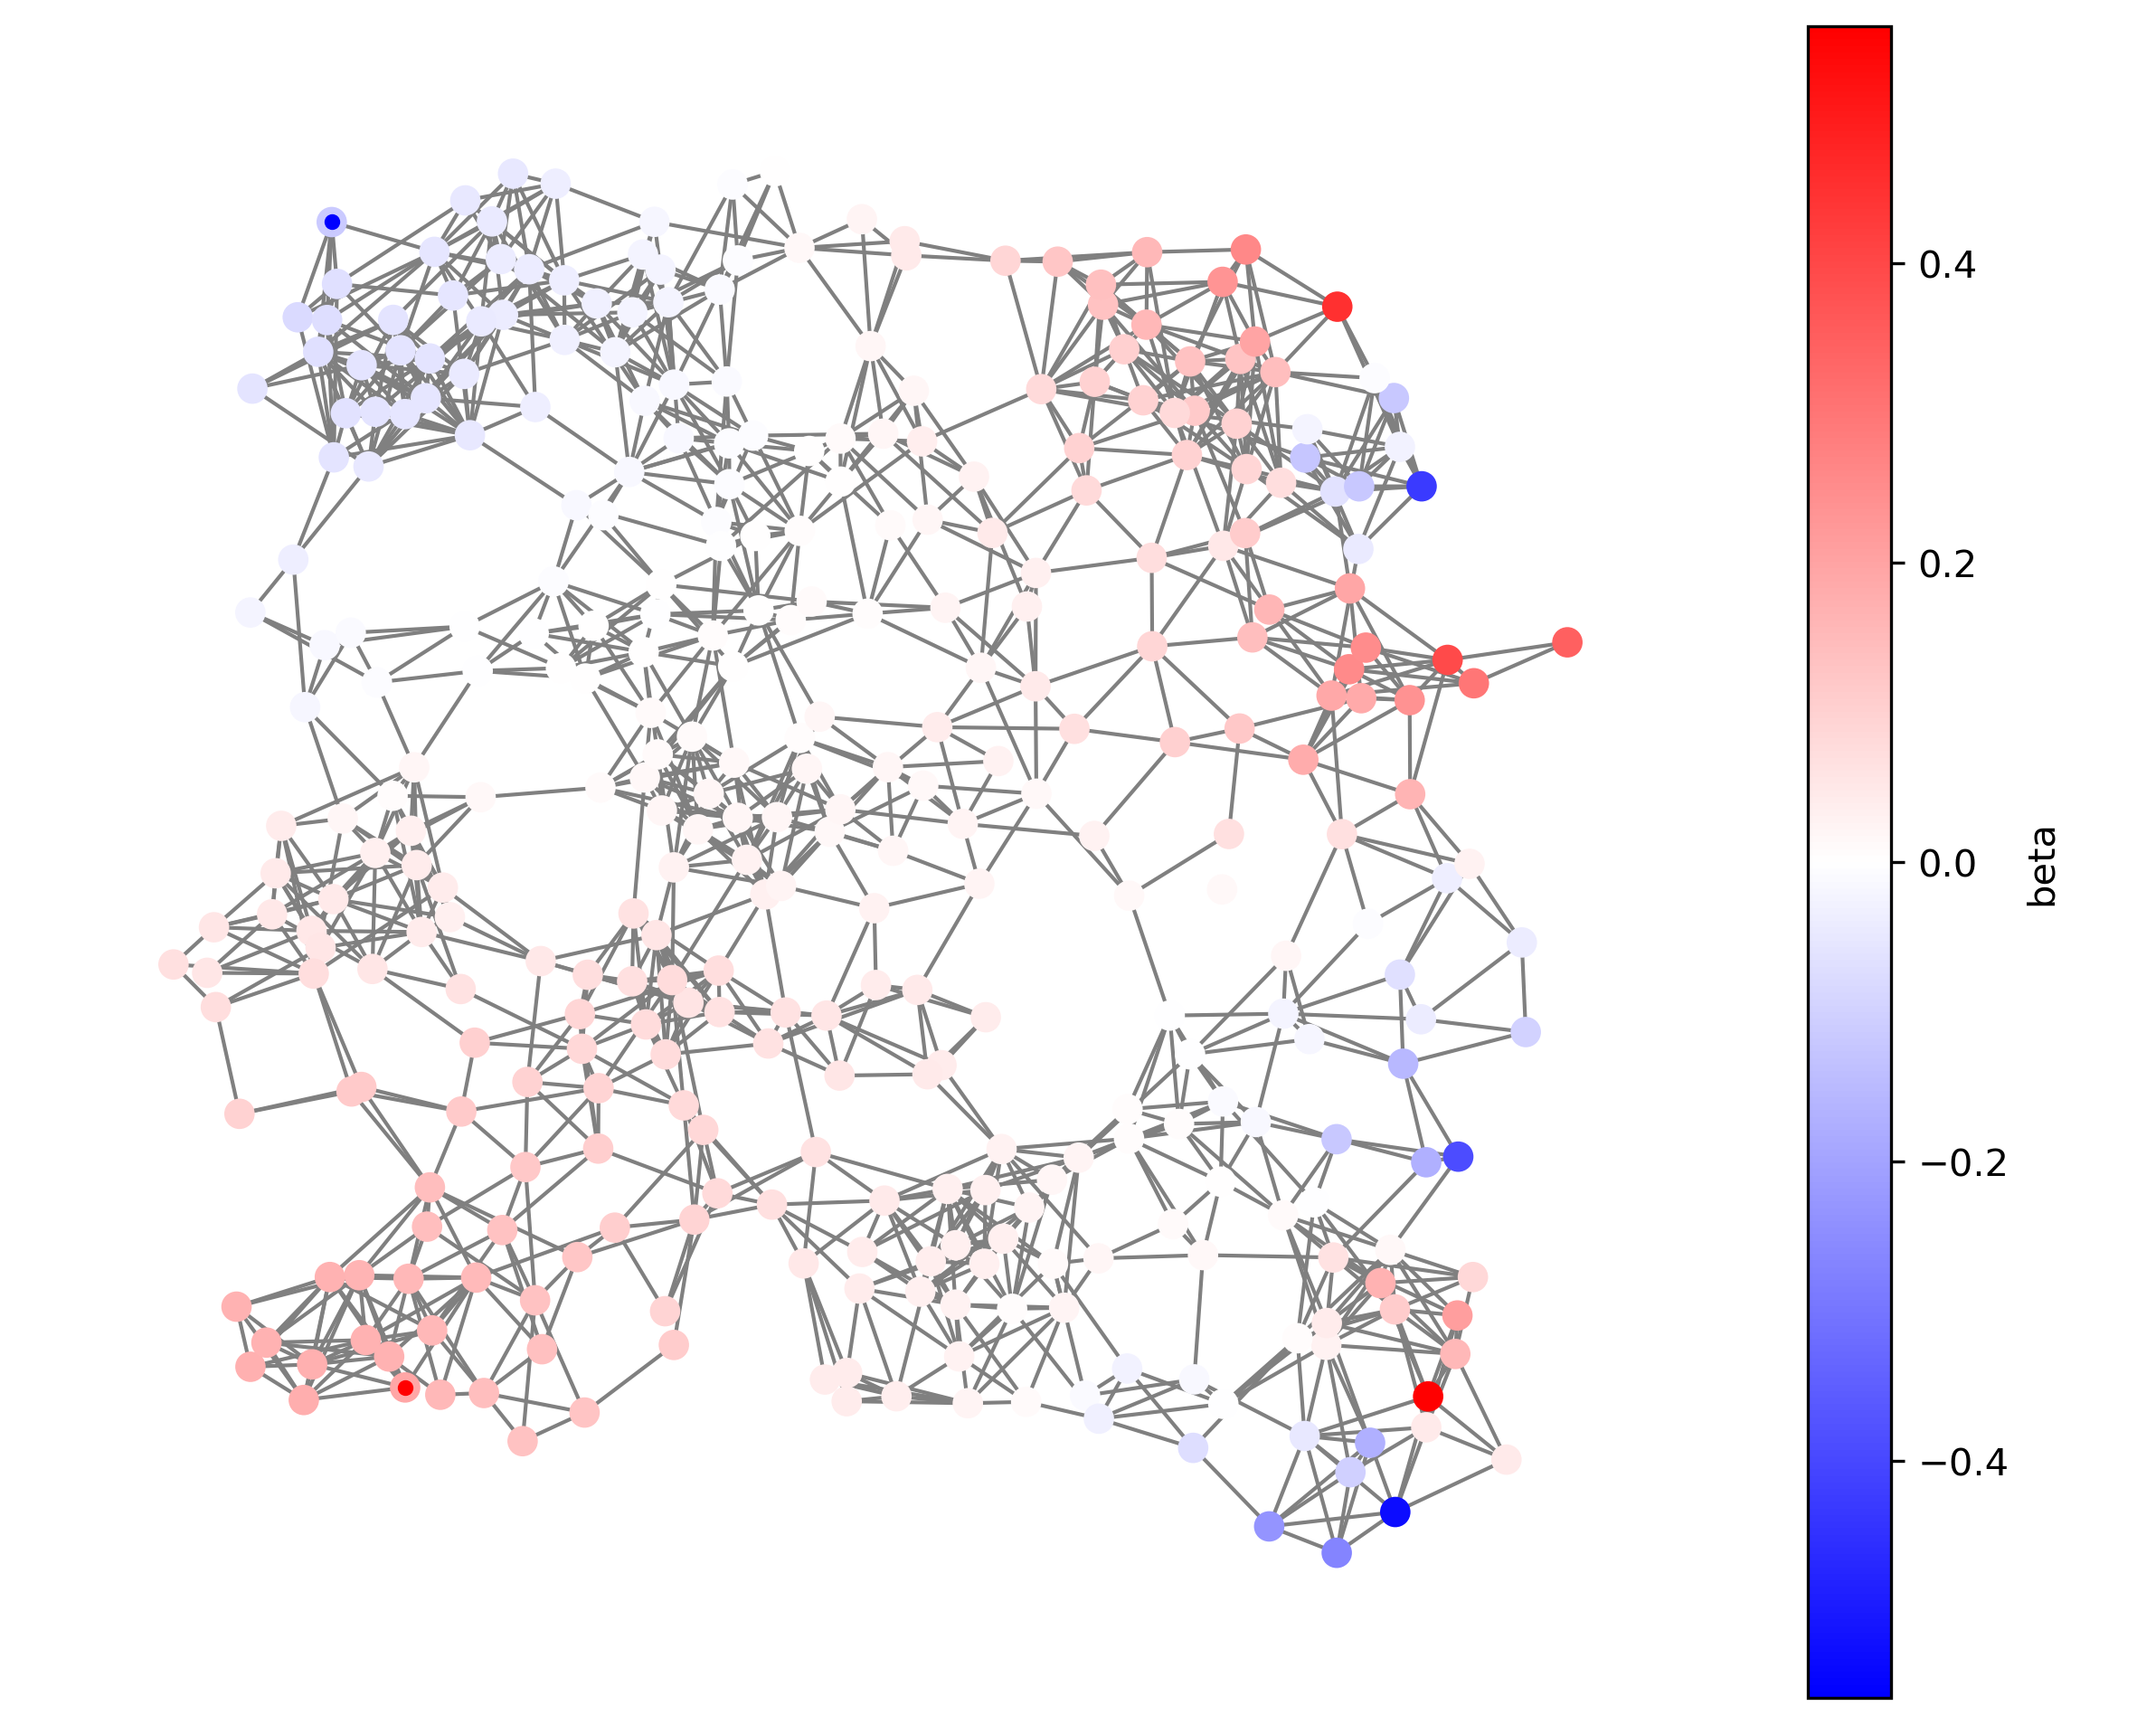

In [688]:
f,[ax,cax] = plt.subplots(1,2, gridspec_kw={"width_ratios":[50,1]},frameon=False, figsize=(10, 8), dpi=300)
canvas_width, canvas_height = f.canvas.get_width_height()
ax.axis('off')
cax.axis('off')


minWeights=np.min(glmBetaVoltageNode)
maxWeights=np.max(glmBetaVoltageNode)
cmap=plt.cm.bwr


node_weight=glmBetaVoltageNode

pos=nx.kamada_kawai_layout(g)
nodeList=g.nodes
numWires=g.number_of_nodes()

h=nx.draw_networkx_nodes(g,pos=pos,node_color=node_weight,cmap=cmap,node_size=50,ax=ax,vmin=-maxWeights,vmax=maxWeights)

h2=nx.draw_networkx_edges(G,pos=pos,ax=ax,edge_color='grey')
# nx.draw_networkx_nodes(g,pos=pos,nodelist=sources,node_color='g',node_size=50,ax=ax)
nx.draw_networkx_nodes(g,pos=pos,nodelist=[drains[1]],node_color='r',node_size=10,ax=ax)
nx.draw_networkx_nodes(g,pos=pos,nodelist=[drains[0]],node_color='b',node_size=10,ax=ax)


# sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=minWeights, vmax=maxWeights))
# sm.set_array([])

cbar = plt.colorbar(h, ax=ax,
                    fraction = 0.05, label='beta')

# animV = animation.FuncAnimation(f, image_draw_voltage, 
#                                frames=range(xlims[0],xlims[1],1)[::10], 
#                                interval=20, 
#                                repeat=False,fargs=(cmap,maxWeights,minWeights))
plt.show()


f.savefig(saveFig+'glmfitNodeVoltage_Class1blue_vs_Class2red_trial9_nw350_nj1350_nback2_manualsources.jpg')


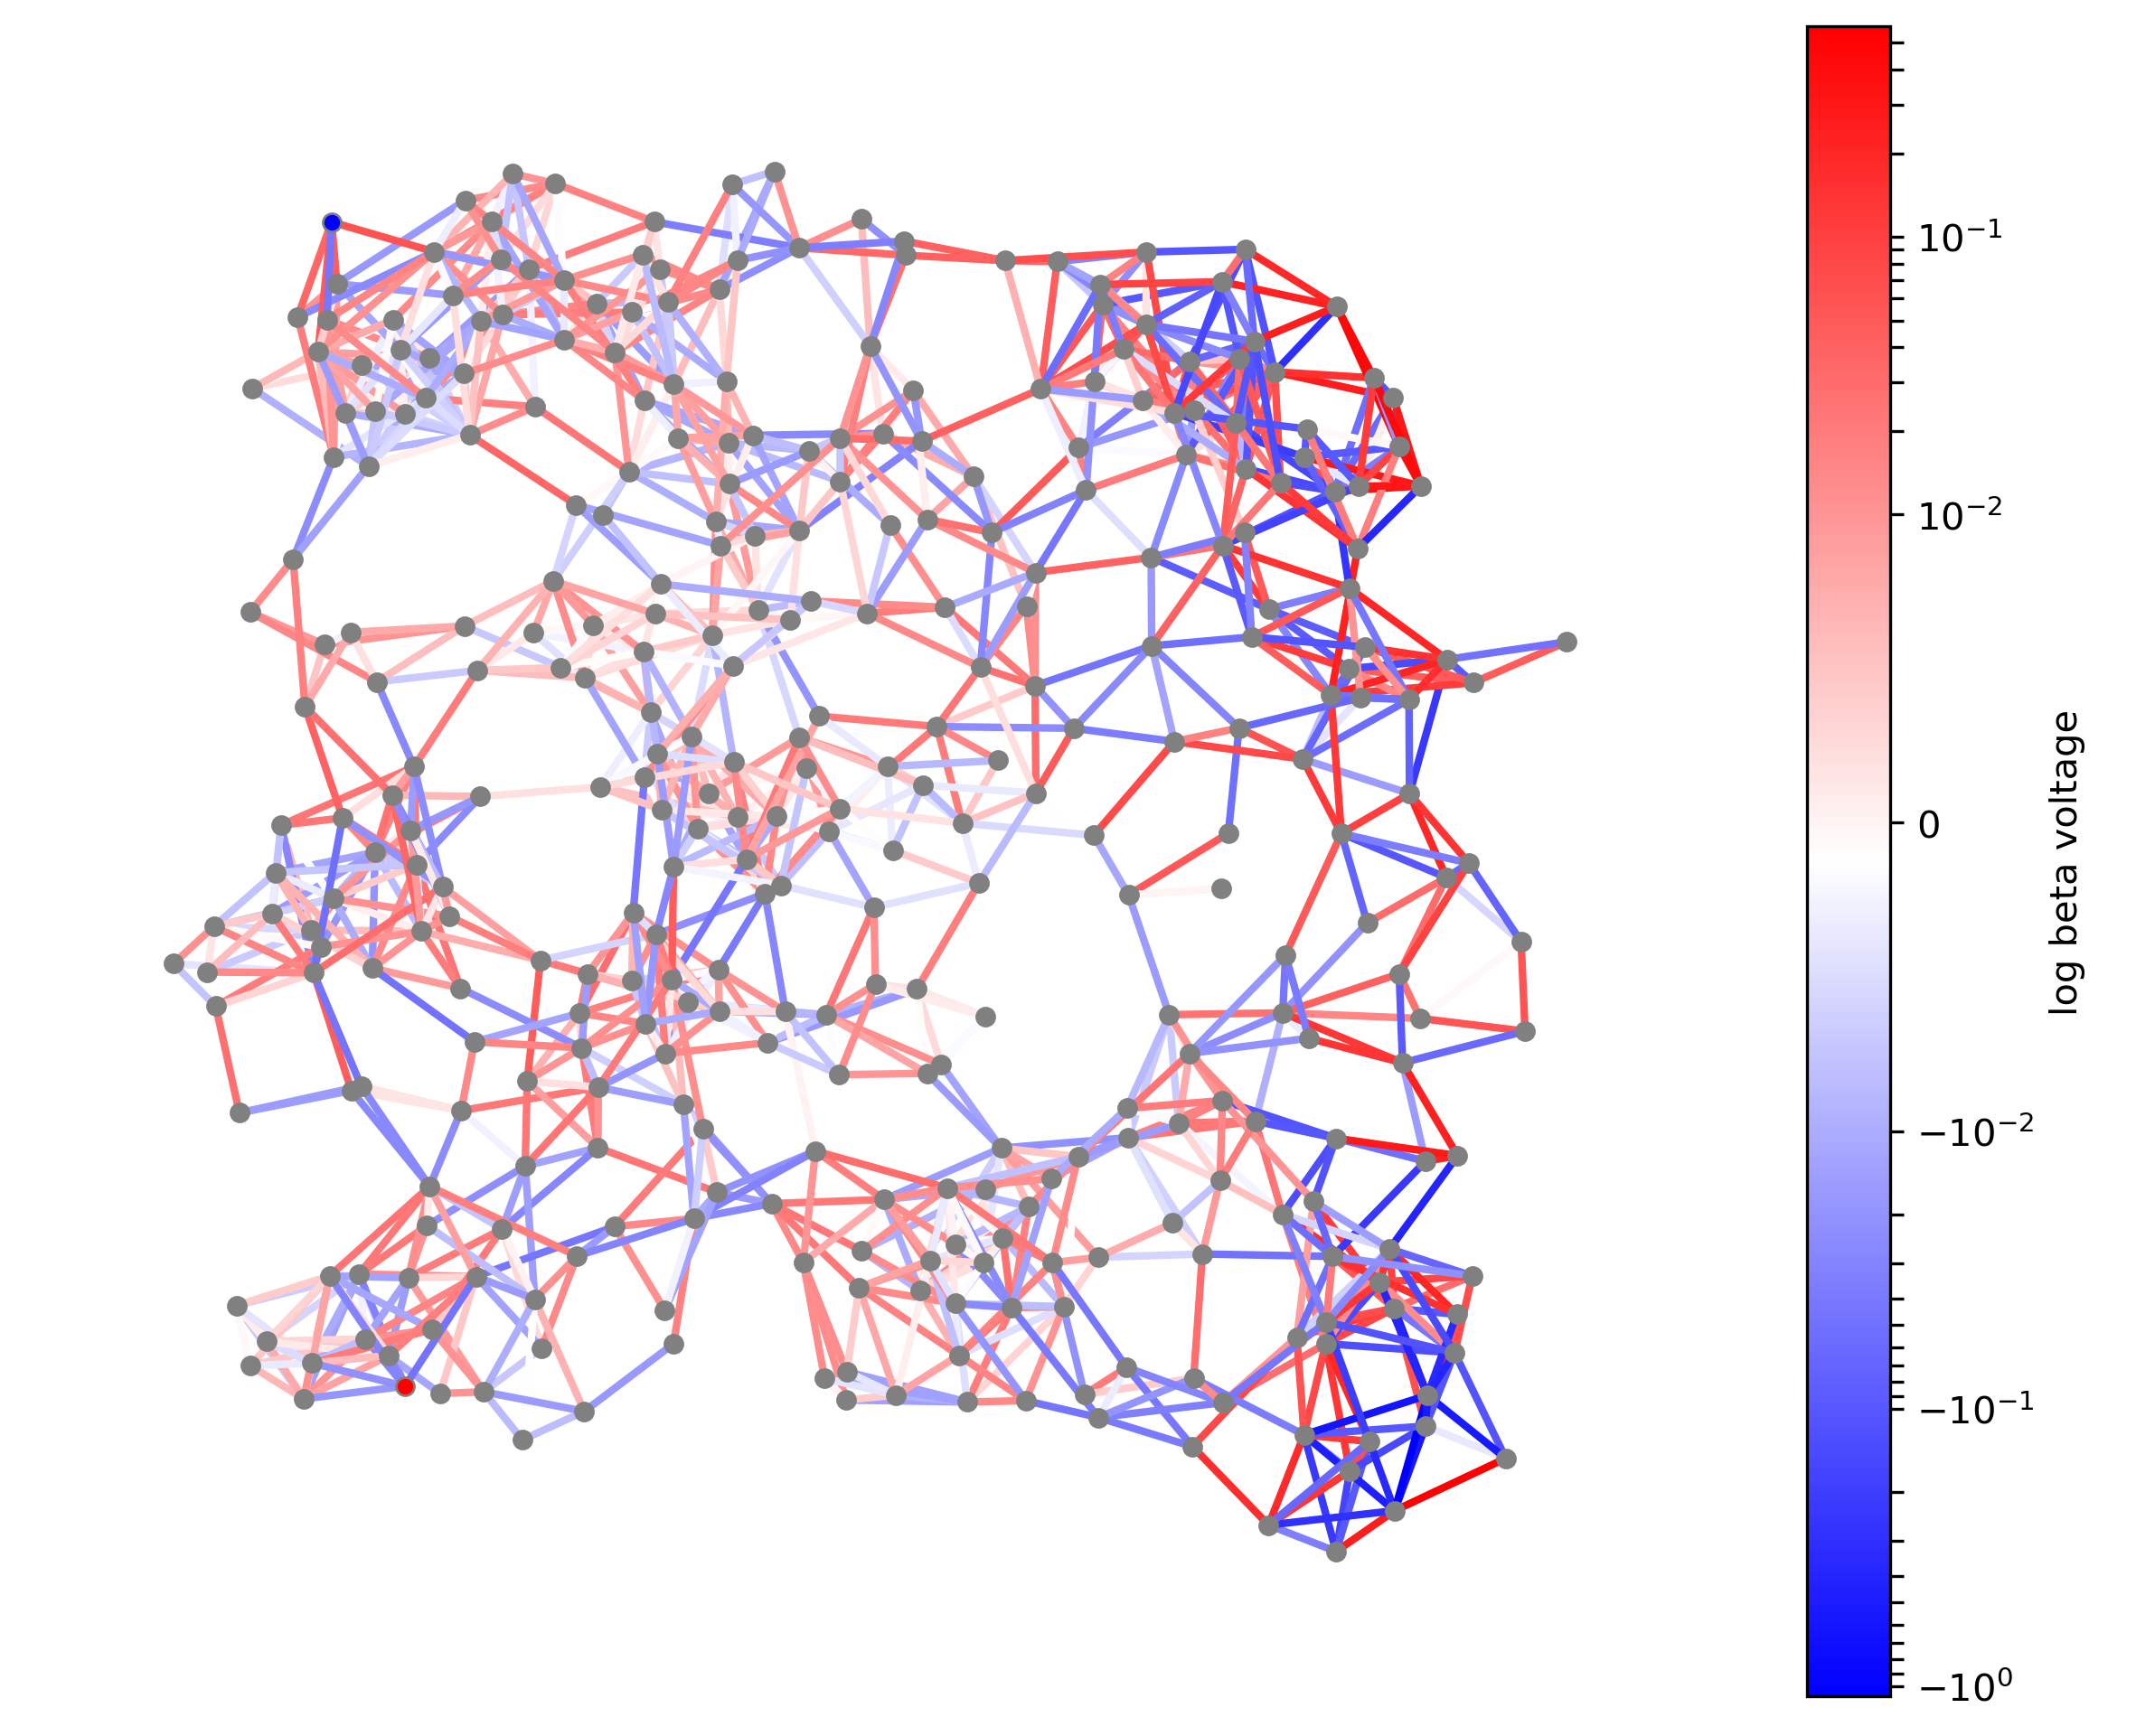

In [346]:
f,[ax,cax] = plt.subplots(1,2, gridspec_kw={"width_ratios":[50,1]},frameon=False, figsize=(10, 8), dpi=300)
canvas_width, canvas_height = f.canvas.get_width_height()
ax.axis('off')
cax.axis('off')
normalize=True

minWeights=np.min(glmBetaVoltageEdges)
maxWeights=np.max(glmBetaVoltageEdges)
cmap=plt.cm.bwr


edge_weight=glmBetaVoltageEdges

pos=nx.kamada_kawai_layout(g)
nodeList=g.nodes
numWires=g.number_of_nodes()

h=nx.draw_networkx_nodes(g,pos=pos,ax=ax,node_size=20,node_color='grey')#,node_color=node_weight,cmap=cmap,node_size=50,ax=ax,vmin=minWeights,vmax=maxWeights)

if normalize:
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=clrs.SymLogNorm(1e-2,base=10,vmin=minWeights, vmax=maxWeights))
    sm.set_array([])

    normweights=sm.norm(edge_weight).data
    normMin=sm.norm(minWeights)
    normMax=sm.norm(maxWeights)   
    h2=nx.draw_networkx_edges(g,pos=pos,ax=ax,width=2,edge_color=normweights,edge_cmap=cmap,edge_vmin=normMin,edge_vmax=normMax)
else:
    h2=nx.draw_networkx_edges(g,pos=pos,ax=ax,width=2,edge_color=edge_weight,edge_cmap=cmap,edge_vmin=-maxWeights,edge_vmax=maxWeights)
# nx.draw_networkx_nodes(g,pos=pos,nodelist=sources,node_color='g',node_size=50,ax=ax)
nx.draw_networkx_nodes(g,pos=pos,nodelist=[drains[1]],node_color='r',node_size=10,ax=ax)
nx.draw_networkx_nodes(g,pos=pos,nodelist=[drains[0]],node_color='b',node_size=10,ax=ax)

cbar = plt.colorbar(sm, ax=ax,
                    fraction = 0.05, label='log beta voltage')

# animV = animation.FuncAnimation(f, image_draw_voltage, 
#                                frames=range(xlims[0],xlims[1],1)[::10], 
#                                interval=20, 
#                                repeat=False,fargs=(cmap,maxWeights,minWeights))
plt.show()
f.savefig(saveFig+'glmfitEdgeVoltage_Class1blue_vs_Class2red_trial9_nw350_nj1350_nback2_manualsources.jpg')


In [689]:
#Coupling:
glmCoupling=loadmat(dataLoc+'beta_glmcoupling_glmfit_350nw_1350nj_trial9.mat') #this is from MATLAB GLMFIT.m

In [690]:
glmCouplingVoltage=glmCoupling['beta'][:,:,1]


In [691]:
f,[ax,cax] = plt.subplots(1,2, gridspec_kw={"width_ratios":[50,1]},frameon=False, figsize=(10, 8), dpi=300)
canvas_width, canvas_height = f.canvas.get_width_height()
ax.axis('off')
cax.axis('off')
normalize=False

minWeights=np.min(glmCouplingVoltage)
maxWeights=np.max(glmCouplingVoltage)
cmap=plt.cm.bwr


edge_weight=glmCouplingVoltage

pos=nx.kamada_kawai_layout(g)
nodeList=g.nodes
numWires=g.number_of_nodes()

h=nx.draw_networkx_nodes(g,pos=pos,ax=ax,node_size=20,node_color='grey')#,node_color=node_weight,cmap=cmap,node_size=50,ax=ax,vmin=minWeights,vmax=maxWeights)

if normalize:
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=clrs.SymLogNorm(1e-2,base=10,vmin=minWeights, vmax=maxWeights))
    sm.set_array([])

    normweights=sm.norm(edge_weight).data
    normMin=sm.norm(minWeights)
    normMax=sm.norm(maxWeights)   
    h2=nx.draw_networkx_edges(g,pos=pos,ax=ax,width=2,edge_color=normweights,edge_cmap=cmap,edge_vmin=normMin,edge_vmax=normMax)
else:
    h2=nx.draw_networkx_edges(g,pos=pos,ax=ax,width=2,edge_color=edge_weight,edge_cmap=cmap,edge_vmin=-maxWeights,edge_vmax=maxWeights)
# nx.draw_networkx_nodes(g,pos=pos,nodelist=sources,node_color='g',node_size=50,ax=ax)
nx.draw_networkx_nodes(g,pos=pos,nodelist=[drains[1]],node_color='r',node_size=10,ax=ax)
nx.draw_networkx_nodes(g,pos=pos,nodelist=[drains[0]],node_color='b',node_size=10,ax=ax)

cbar = plt.colorbar(sm, ax=ax,
                    fraction = 0.05, label='log beta voltage')

# animV = animation.FuncAnimation(f, image_draw_voltage, 
#                                frames=range(xlims[0],xlims[1],1)[::10], 
#                                interval=20, 
#                                repeat=False,fargs=(cmap,maxWeights,minWeights))
plt.show()
# f.savefig(saveFig+'glmfitEdgeVoltage_Class1blue_vs_Class2red_trial9_nw350_nj1350_nback2_manualsources.jpg')


ValueError: RGBA sequence should have length 3 or 4

In [697]:
z=np.zeros((len(edge_weight),len(edge_weight)))
for i in range(len(edge_weight)):
    for j in range(len(edge_weight)):
        if edge_weight[i,j] > 0.7*np.max(edge_weight) or edge_weight[i,j] < 0.7*np.min(edge_weight):
            z[i,j]=edge_weight[i,j]
        elif a[i,j]==0:
            z[i,j]=0

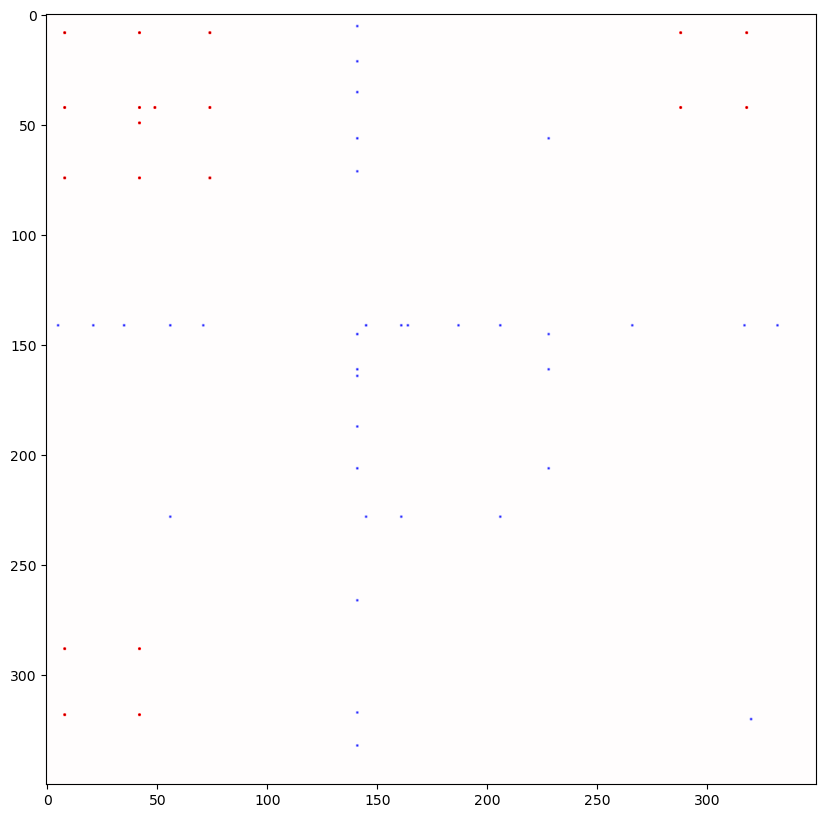

In [541]:
f=plt.figure(figsize=(10,10))
plt.imshow(z,cmap=plt.cm.seismic,vmin=-np.max(edge_weight),vmax=np.max(edge_weight))
plt.rcParams['pdf.fonttype'] = 42

# X,Y = np.meshgrid(np.arange(z.shape[1]),np.arange(z.shape[0]))
# plt.scatter(X,Y,c=z, s=20, marker="o",cmap=plt.cm.seismic,vmin=-np.max(edge_weight),vmax=np.max(edge_weight))
# ax3=plt.gca()
# ax3.set_aspect("equal")
# ax3.margins(0)

plt.show()


In [538]:
f.savefig(saveFig+'glmcoupling_glmfit_350nw_1350nj_trial9_top20percent.pdf',format='pdf',dpi=300)

In [698]:
topnodes=np.where(z)

In [699]:
topnodes

(array([  0,   0,   0, ..., 348, 348, 349]),
 array([141, 228, 320, ..., 228, 320, 141]))

In [700]:
topnodesvals=z[topnodes[0],topnodes[1]]

In [701]:
topnodesvals

array([-0.1631673 , -0.14311522, -0.15251893, ..., -0.14079946,
       -0.15374664, -0.14137835])

In [702]:
newEdgeList=np.array(topnodes).T

In [703]:
newEdgeList

array([[  0, 141],
       [  0, 228],
       [  0, 320],
       ...,
       [348, 228],
       [348, 320],
       [349, 141]])

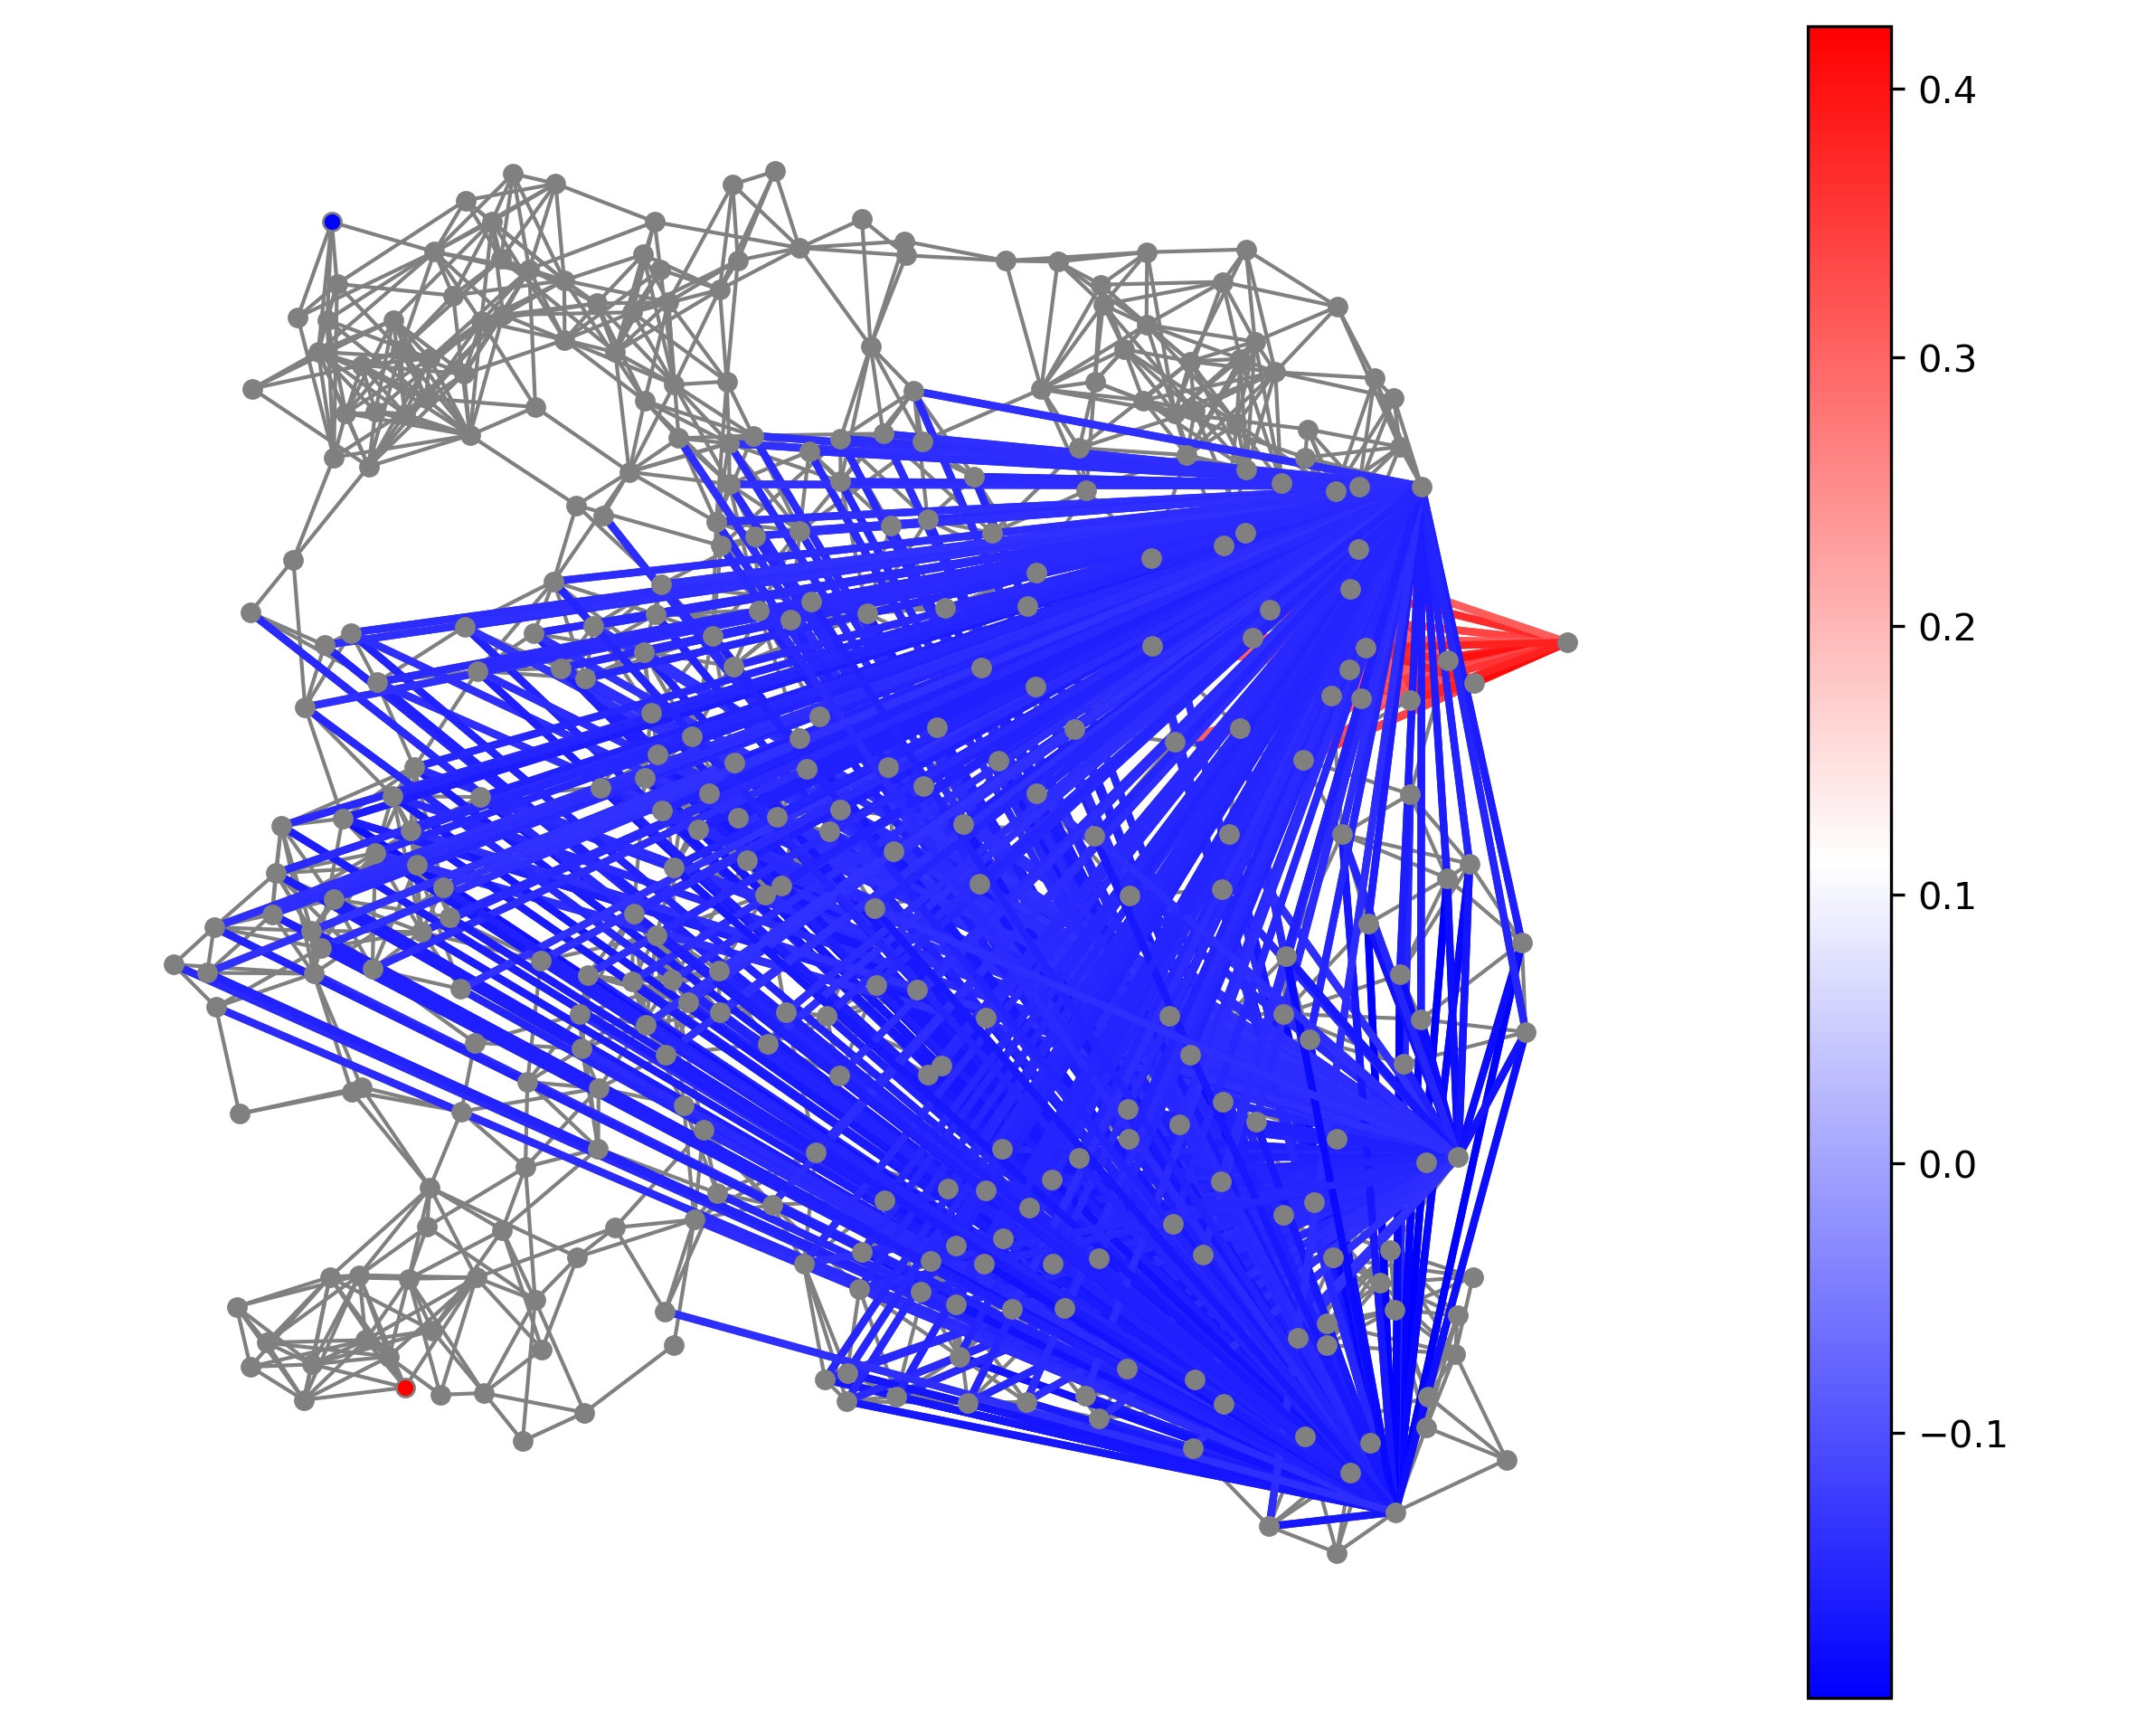

In [705]:
f,[ax,cax] = plt.subplots(1,2, gridspec_kw={"width_ratios":[50,1]},frameon=False, figsize=(10, 8), dpi=300)
canvas_width, canvas_height = f.canvas.get_width_height()
ax.axis('off')
cax.axis('off')

minWeights=np.min(topnodesvals)
maxWeights=np.max(topnodesvals)
cmap=plt.cm.bwr


pos=nx.kamada_kawai_layout(g)
nodeList=g.nodes
numWires=g.number_of_nodes()

h=nx.draw_networkx_nodes(g,pos=pos,ax=ax,node_size=20,node_color='grey')#,node_color=node_weight,cmap=cmap,node_size=50,ax=ax,vmin=minWeights,vmax=maxWeights)
h2=nx.draw_networkx_edges(g,pos=pos,ax=ax,width=1,edge_color='grey')

h2=nx.draw_networkx_edges(g,pos=pos,ax=ax,width=2,edge_color=topnodesvals,edgelist=tuple(newEdgeList),edge_cmap=cmap,edge_vmin=minWeights,edge_vmax=maxWeights)
# nx.draw_networkx_nodes(g,pos=pos,nodelist=sources,node_color='g',node_size=50,ax=ax)
nx.draw_networkx_nodes(g,pos=pos,nodelist=[drains[1]],node_color='r',node_size=10,ax=ax)
nx.draw_networkx_nodes(g,pos=pos,nodelist=[drains[0]],node_color='b',node_size=10,ax=ax)

cbar = plt.colorbar(h2, ax=ax,
                    fraction = 0.05, label='')

# animV = animation.FuncAnimation(f, image_draw_voltage, 
#                                frames=range(xlims[0],xlims[1],1)[::10], 
#                                interval=20, 
#                                repeat=False,fargs=(cmap,maxWeights,minWeights))
plt.show()
# f.savefig(saveFig+'glmfitEdgeVoltage_Class1blue_vs_Class2red_trial9_nw350_nj1350_nback2_manualsources.jpg')
